In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t$$

where $U$ is the potential function (势能函数) and $B_t$ is the standard Brownian motion.

### Example
Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$, and $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [2]:
def npdensity1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def npdensity2(z):
    z = z.reshape(-1, 2)
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return np.exp(-u)

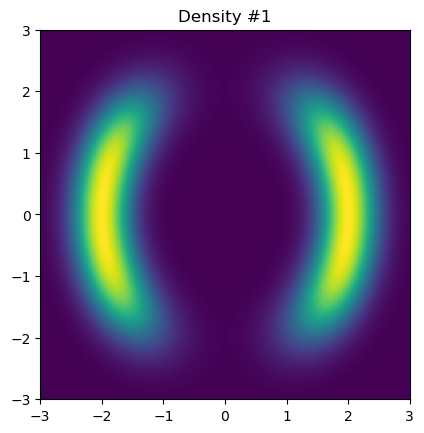

In [3]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

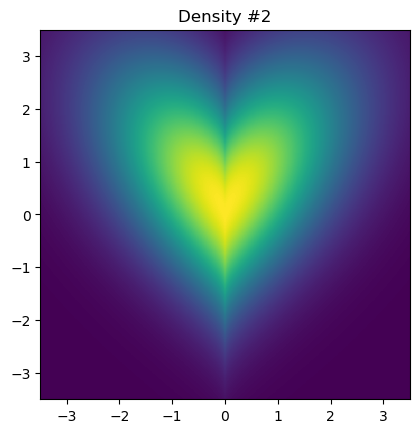

In [4]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity2(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Density #2')
plt.show()

## Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

$$X_{k+1} = X_{k} - \gamma_{k+1}\nabla U(X_k) + \sqrt{2\gamma_{k+1}}Z_{k+1}$$

where $\gamma_{k+1}$ is the step size and $Z_{k+1}$ is a sample from $\mathcal{N}(0, I)$ respectively at the $k+1$-th time-step.

In practice, there are various tricks to set $\gamma_{k+1}$ and $X_0$, the initial seed. However, in the following examples, I've used a constant step-size and have sampled $X_0$ from $\mathcal{N}(0, I)$.

The above simulation of Langevin dynamics can be used to draw samples from densities of the form $p(x) = \frac{e^{-U(x)}}{Z}$ where Z may or may not be known. It is assumed that the gradient of $U$ is $L$-Lipschtiz. 

1. 对应的势能函数U(x)定义为负对数概率密度函数的相反数：

    $$U(x) = -log(p(x))$$

    将概率密度函数代入，可以得到高斯分布的势能函数表达式为：

    $$U(x) = (1/2) * (x - μ)^T * Σ^(-1) * (x - μ) + (k/2) * log(2 * π) + (1/2) * log(|Σ|)$$

    势能函数表示了系统在不同状态下的能量值，对于高斯分布而言，势能函数的形式是二次型，与平方差和协方差矩阵之间的关系密切相关。势能函数在统计物理学、机器学习和优化等领域中具有重要的应用，例如在高斯过程回归、变分推断和能量最小化等问题中常被使用。
    势能函数描述了系统的能量随着系统状态的变化而变化的方式。在物理学中，势能函数通常用于描述粒子或物体在外部力场中的势能。在优化问题中，势能函数用于衡量解的质量或目标函数的值.在梯度下降法中，势能函数的梯度信息被用来确定下一步的移动方向和步长。根据梯度的方向，可以判断函数在当前位置上升或下降的趋势，从而决定向梯度的反方向移动一定的距离。这样，在每次迭代中，通过利用梯度信息，我们可以逐步接近或达到势能函数的最小值或最优解

2. 势能函数的导数就是梯度函数。在多变量的情况下，梯度是一个向量，其中每个分量是势能函数对相应变量的偏导数。梯度函数给出了势能函数在不同变量方向上的变化率。

    数学上，对于一个具有多个变量的函数，其梯度由偏导数组成。偏导数表示了函数在每个变量上的变化率，而梯度则是将这些偏导数组合成一个向量。

    对于势能函数U(x)，其中x是多个变量的向量，势能函数的梯度函数∇U(x)可以表示为：

    $$∇U(x) = (∂U/∂x₁, ∂U/∂x₂, ..., ∂U/∂xₙ)$$

    其中∂U/∂x₁表示势能函数U(x)对变量x₁的偏导数，以此类推。

    梯度函数是一个非常重要的概念，它在优化算法、梯度下降法、梯度上升法和其他许多数学和机器学习算法中起着关键作用。梯度提供了函数在某个点的变化方向和变化速率的信息，可以用于优化问题的求解、参数更新和最小化能量等应用。

In [5]:
def potential1(z):
    z = z.view(-1, 2)
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u

def potential2(z):
    z = z.view(-1, 2)
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return u

autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False)

outputs: 求导的因变量（需要求导的函数）

inputs: 求导的自变量

grad_outputs:  如果 outputs为标量，则grad_outputs=None,也就是说，可以不用写; 

---------------------------------------------------------------------------

先假设 $x, y$ 为一维向量, 即可设自变量因变量分别为
$\mathbf{x}=\left(x_1, x_2, \cdots, x_n\right) \in \mathbb{R}^n, y=f(\mathbf{x})=\left(y_1, y_2, \cdots, y_m\right) \in \mathbb{R}^m$ ，其对应的 Jacobi 矩阵为
$$
J=\left(\begin{array}{cccc}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \cdots & \frac{\partial y_1}{\partial x_n} \\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \cdots & \frac{\partial y_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x_1} & \frac{\partial y_m}{\partial x_2} & \cdots & \frac{\partial y_m}{\partial x_n}
\end{array}\right)
$$
grad_outputs 是一个shape 与 outputs 一致的向量, 即
$$
\text { grad_outputs }=\left(\begin{array}{llll}
a_{11} & a_{12} & \cdots & a_{1 m}
\end{array}\right)^T,
$$
在给定grad_outputs 之后，真正返回的梯度为
$$
\operatorname{grad}=\left(\begin{array}{c}
a_1 \frac{\partial y_1}{\partial x_1}+a_2 \frac{\partial y_2}{\partial x_2}+\cdots+a_m \frac{\partial y_m}{\partial x_1} \\
a_1 \frac{\partial y_2}{\partial x_2}+a_2 \frac{\partial y_1}{\partial x_2}+\cdots+a_m \frac{\partial y_m}{\partial x_2} \\
\cdots \cdots \cdots+a_m \frac{\partial y_m}{\partial x_n}
\end{array}\right) \in \mathbb{R}^n .
$$
为方便下文叙述我们引入记号 $g r a d=J \otimes g r a d \_o u t p u t s$.
其次假设 $x=\left(x_1, \cdots, x_n\right) \in \mathbb{R}^n, \mathbf{y}=\left(\mathbf{y}_{\mathbf{1}}, \cdots, \mathbf{y}_{\mathbf{t}}\right) \in \mathbb{R}^{s \times t}$, 第i个列向量对应的Jacobi矩 阵为
$$
J_i, 1 \leq i \leq t
$$
此时的grad_outputs 为(维度与outputs-致)
$$
\text { grad_outputs }=\left(g o_1, \cdots, g o_t\right) \in \mathbb{R}^{s \times t}
$$
由第一种情况，我们有
$$
\operatorname{grad}=\sum_{i=1}^t J_i \otimes g o_i .
$$
也就是说对输出变量的列向量求导，再经过权重累加。
若 $x=\left(\mathbf{x}_{\mathbf{1}}, \cdots, \mathbf{x}_{\mathbf{p}}\right) \in \mathbb{R}^{n \times p}, \mathbf{y} \in \mathbb{R}^m$, 沿用第一种情况记号
$g r a d=\left(\begin{array}{lll}\operatorname{rrad}_1 \cdots & \operatorname{grad}_p\end{array}\right)$, 其中每一个 $\operatorname{grad}_i$ 均由第一种方法得出，
即对输入变量列向量求导，之后按眧原先顺序排列即可。

In [6]:
def unadjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    for i in tqdm(range(n_samples + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

Run the ULA and render the empirical density.

In [7]:
samples1 = unadjusted_langevin_algorithm(potential1)
samples2 = unadjusted_langevin_algorithm(potential2)

/var/tmp/ipykernel_1034/50480830.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

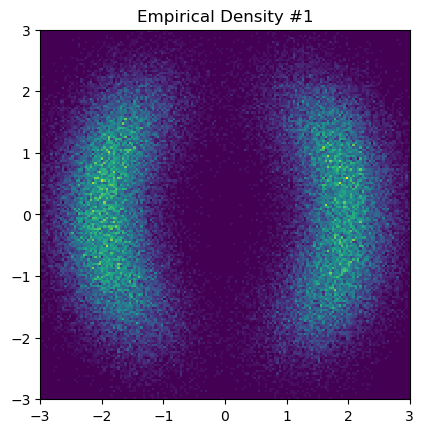

In [8]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

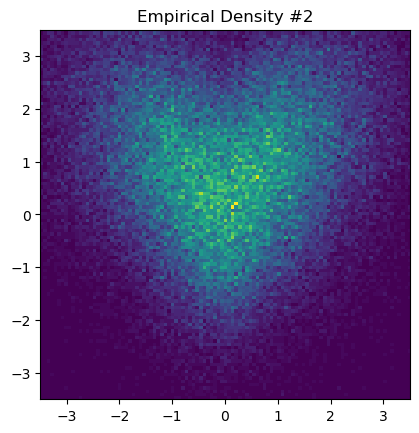

In [9]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Metropolis-adjusted Langevin Algorithm (MALA)

New samples are proposed using the Euler-Maruyama scheme as before, **but are accepted/rejected using the Metropolis-Hastings algorithm, i.e., the acceptance propability is given by**

$$\alpha = \min \left\{1, \frac{p(x_{k+1})Q(x_k|x_{k+1})}{p(x_{k})Q(x_{k+1}|x_{k})}\right\}$$

where  proposal distribution

$$Q(x'|x) \propto \exp\left(-\frac{1}{4\gamma}\|x' - x + \gamma\nabla U(x)\|^2\right)$$

I thought this becuase 
$$ \begin{aligned}
& x-x^{\prime}=-d t \nabla U\left(x^{\prime}\right)+\mathcal{N}\left(0, \sigma^2 d t\right) \\
& x \sim \mathcal{N}\left(x^{\prime}-\nabla U\left(x^{\prime}\right) d t, \sigma^2 d t\right)
\end{aligned}$$

or 
$$
x_{n+1} = x_n + \nabla \log p(x_n) \epsilon + \sigma \sqrt{2 \epsilon}\ z \\
x \sim \mathcal{N}\left(x^{\prime}-\nabla U\left(x^{\prime}\right) d t, 2 \sigma^2\epsilon d t\right)
$$

In [34]:
def log_Q(potential, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    pbar = tqdm(range(n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        # the potential function is negative log, here the proposal distribution 
        log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
                    log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

In [11]:
samples1 = metropolis_adjusted_langevin_algorithm(potential1)
samples2 = metropolis_adjusted_langevin_algorithm(potential2)

/var/tmp/ipykernel_1034/1973320184.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(range(n_samples + burn_in))


  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

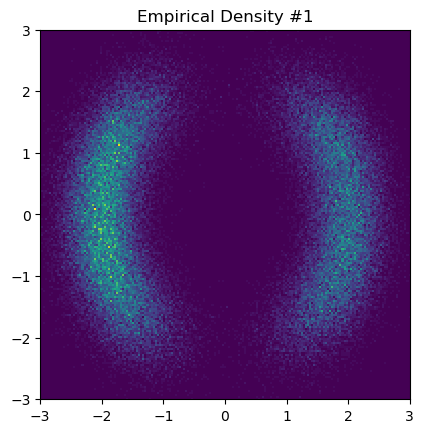

In [12]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

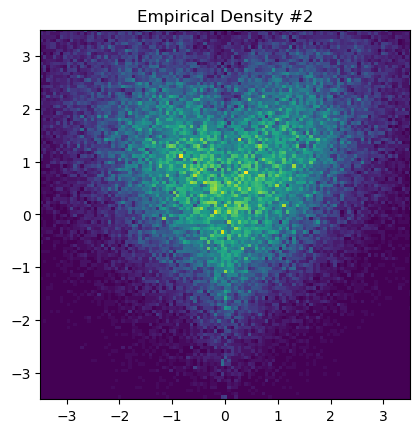

In [13]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Metropolis-Hastings Algorithm for comparison

In [14]:
def metropolis_hastings(target_density, size=100000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in tqdm(range(size)):
        xt_candidate = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return samples

In [15]:
samples1 = metropolis_hastings(npdensity1)
samples2 = metropolis_hastings(npdensity2)

/var/tmp/ipykernel_1034/2867406304.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(size)):


  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

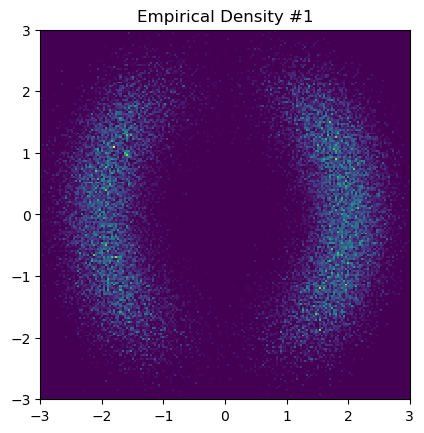

In [16]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

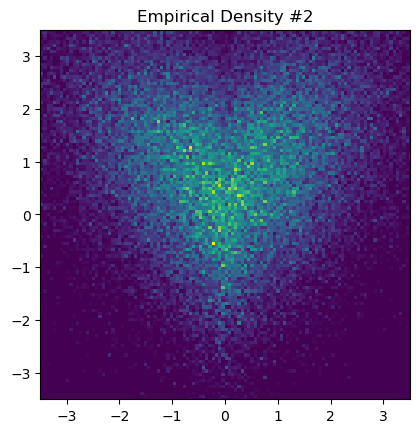

In [17]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

In [30]:
import numpy as np

def langevin_monte_carlo(target_distribution, initial_position, num_samples, step_size, temperature):
    samples = [initial_position]
    current_position = initial_position

    for _ in range(num_samples):
        # 从正态分布中采样随机力
        random_force = np.random.normal(0, np.sqrt(2 * step_size * temperature), size=current_position.shape)

        # 计算目标分布的梯度
        gradient = target_distribution.gradient(current_position)

        # 更新当前位置
        current_position = current_position - step_size * gradient + random_force

        # 添加到样本集合中
        samples.append(current_position)

    return samples

# 示例目标分布：二维高斯分布
class TargetDistribution:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov

    def pdf(self, x):
        return np.exp(-0.5 * (x - self.mean).T @ np.linalg.inv(self.cov) @ (x - self.mean)) / (2 * np.pi * np.sqrt(np.linalg.det(self.cov)))

    def gradient(self, x):
        return np.linalg.inv(self.cov) @ (x - self.mean)

# 参数设置
mean = np.array([0, 0])
cov = np.array([[1, 0], [0, 1]])
target = TargetDistribution(mean, cov)
initial_position = np.array([0, 0])
num_samples = 1000
step_size = 0.1
temperature = 1.0

# 运行Langevin Monte Carlo
samples = langevin_monte_carlo(target, initial_position, num_samples, step_size, temperature)

## 打印结果
#for sample in samples:
#    print(sample)


In [31]:
sample_array = np.asarray( samples )

In [32]:
sample_array.shape

(1001, 2)

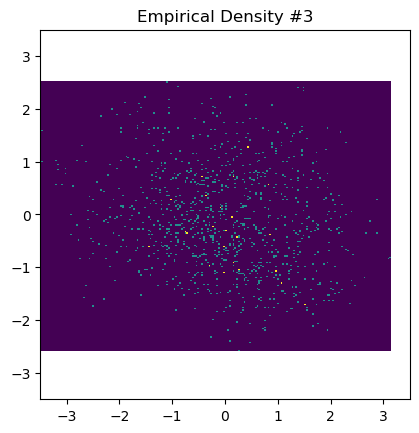

In [33]:
plt.hist2d(sample_array[:,0], sample_array[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #3')
plt.show()